In [2]:
import sys
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import os

# Se var notebooken körs från
print("CWD:", os.getcwd())

# Lägg till projektroten så att `import src...` alltid funkar
sys.path.append(str(Path("..").resolve()))

# Kolla att data finns
print("Raw files:", [p.name for p in Path("../data/raw").iterdir()])

CWD: /Users/emanuelmalki/Documents/cnaim-pof-validation/notebook
Raw files: ['failures.csv', 'assets.csv', 'README.md']


In [3]:
from src.io import load_assets, load_failures
from src.quality import validate_assets, validate_failures

assets = load_assets("../data/raw/assets.csv")
failures = load_failures("../data/raw/failures.csv")

validate_assets(assets)
validate_failures(failures)

In [4]:
from src.io import load_assets, load_failures
from src.quality import validate_assets, validate_failures

assets = load_assets("../data/raw/assets.csv")
failures = load_failures("../data/raw/failures.csv")

validate_assets(assets)
validate_failures(failures)

In [5]:
assets.head()

,asset_id,asset_type,installation_year,cnaim_pof
0,1,cable,2005,0.020
1,2,transformer,2010,0.010
2,3,cable,2012,0.030
3,4,switch,2018,0.005


In [6]:
import os
os.getcwd()

'/Users/emanuelmalki/Documents/cnaim-pof-validation/notebook'

In [7]:

import os
os.listdir("..")


['.DS_Store',
 'requirements.txt',
 'tests',
 'README.md',
 '.gitignore',
 '.venv',
 'notebook',
 '.git',
 'data',
 'reports',
 'src']

In [8]:
from pathlib import Path

list(Path("../data").iterdir())

[PosixPath('../data/processed'), PosixPath('../data/raw')]

In [9]:
list(Path("../data/raw").iterdir())

[PosixPath('../data/raw/failures.csv'),
 PosixPath('../data/raw/assets.csv'),
 PosixPath('../data/raw/README.md')]

In [10]:
import pandas as pd
from pathlib import Path

raw = Path("../data/raw")

assets = pd.DataFrame({
    "asset_id": [1,2,3,4],
    "asset_type": ["cable","transformer","cable","switch"],
    "installation_year": [2005,2010,2012,2018],
    "cnaim_pof": [0.02,0.01,0.03,0.005]
})

failures = pd.DataFrame({
    "failure_id": [101,102],
    "asset_id": [1,3],
    "failure_date": ["2020-05-01","2022-09-10"]
})

assets.to_csv(raw/"assets.csv", index=False)
failures.to_csv(raw/"failures.csv", index=False)

print("Testdata skapad")

Testdata skapad


In [11]:
list(Path("../data/raw").iterdir())

[PosixPath('../data/raw/failures.csv'),
 PosixPath('../data/raw/assets.csv'),
 PosixPath('../data/raw/README.md')]

In [12]:
assets = load_assets("../data/raw/assets.csv")
failures = load_failures("../data/raw/failures.csv")

assets.head()

,asset_id,asset_type,installation_year,cnaim_pof
0,1,cable,2005,0.020
1,2,transformer,2010,0.010
2,3,cable,2012,0.030
3,4,switch,2018,0.005


In [13]:
from src.exposure import build_asset_years

END_YEAR = 2026
asset_years = build_asset_years(assets, failures, end_year=END_YEAR)

asset_years.head(), asset_years.shape

(   asset_id  year asset_type  installation_year  cnaim_pof  age  \
 0         1  2005      cable               2005       0.02    0   
 1         1  2006      cable               2005       0.02    1   
 2         1  2007      cable               2005       0.02    2   
 3         1  2008      cable               2005       0.02    3   
 4         1  2009      cable               2005       0.02    4   
 
    failures_in_year  exposure_years  
 0                 0             1.0  
 1                 0             1.0  
 2                 0             1.0  
 3                 0             1.0  
 4                 0             1.0  ,
 (63, 8))

In [14]:
from src.exposure import build_asset_years

asset_years = build_asset_years(assets, failures, end_year=2026)
asset_years.head(), asset_years.shape

(   asset_id  year asset_type  installation_year  cnaim_pof  age  \
 0         1  2005      cable               2005       0.02    0   
 1         1  2006      cable               2005       0.02    1   
 2         1  2007      cable               2005       0.02    2   
 3         1  2008      cable               2005       0.02    3   
 4         1  2009      cable               2005       0.02    4   
 
    failures_in_year  exposure_years  
 0                 0             1.0  
 1                 0             1.0  
 2                 0             1.0  
 3                 0             1.0  
 4                 0             1.0  ,
 (63, 8))

In [15]:
asset_years["asset_id"].nunique(), assets["asset_id"].nunique()
asset_years["failures_in_year"].sum()

np.int64(2)

In [16]:
from pathlib import Path
Path("../data/processed").mkdir(parents=True, exist_ok=True)
asset_years.to_csv("../data/processed/asset_years.csv", index=False)

In [17]:
observed = (
    asset_years
    .groupby("asset_type")
    .agg(
        total_failures=("failures_in_year", "sum"),
        total_exposure=("exposure_years", "sum"),
        cnaim_pof=("cnaim_pof", "mean")
    )
)

observed["observed_failure_rate"] = (
    observed["total_failures"] /
    observed["total_exposure"]
)

observed

,total_failures,total_exposure,cnaim_pof,observed_failure_rate
asset_type,,,,
cable,2,37.0,0.024054,0.054054
switch,0,9.0,0.005000,0.000000
transformer,0,17.0,0.010000,0.000000


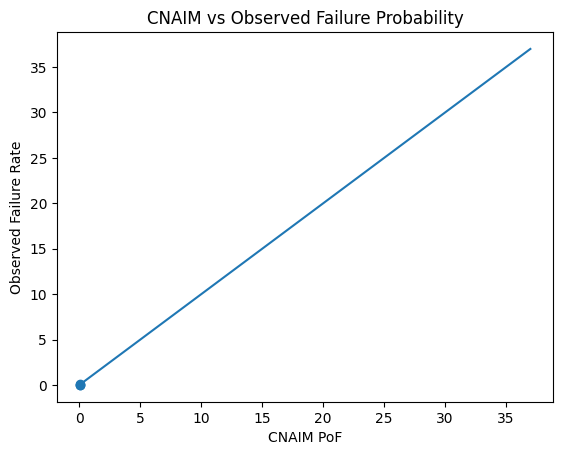

In [18]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(
    observed["cnaim_pof"],
    observed["observed_failure_rate"]
)

plt.plot([0, observed.max().max()],
         [0, observed.max().max()])

plt.xlabel("CNAIM PoF")
plt.ylabel("Observed Failure Rate")
plt.title("CNAIM vs Observed Failure Probability")

plt.show()

In [19]:
observed["model_error"] = (
    observed["observed_failure_rate"]
    - observed["cnaim_pof"]
)

observed.sort_values("model_error")

,total_failures,total_exposure,cnaim_pof,observed_failure_rate,model_error
asset_type,,,,,
transformer,0,17.0,0.010000,0.000000,-0.010
switch,0,9.0,0.005000,0.000000,-0.005
cable,2,37.0,0.024054,0.054054,0.030


In [20]:
weibull_data = asset_years.copy()

weibull_data["event"] = (
    weibull_data["failures_in_year"] > 0
).astype(int)

weibull_data.head()

,asset_id,year,asset_type,installation_year,cnaim_pof,age,failures_in_year,exposure_years,event
0,1,2005,cable,2005,0.02,0,0,1.0,0
1,1,2006,cable,2005,0.02,1,0,1.0,0
2,1,2007,cable,2005,0.02,2,0,1.0,0
3,1,2008,cable,2005,0.02,3,0,1.0,0
4,1,2009,cable,2005,0.02,4,0,1.0,0


In [21]:
from scipy.stats import weibull_min

failure_ages = weibull_data.loc[
    weibull_data["event"] == 1, "age"
]

shape, loc, scale = weibull_min.fit(
    failure_ages,
    floc=0
)

shape, scale

(np.float64(5.917534922094154), np.float64(13.539309509851217))

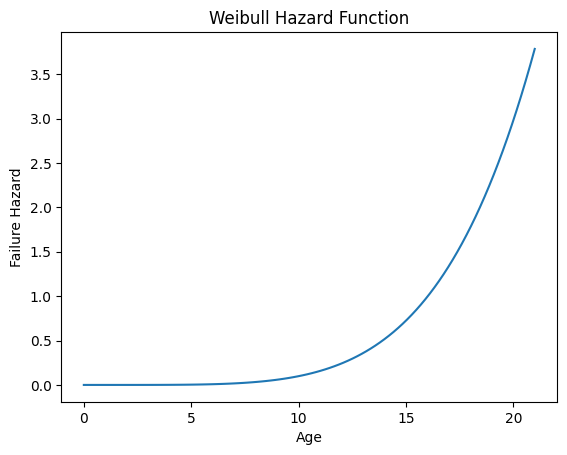

In [22]:
import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(0, weibull_data["age"].max(), 100)

hazard = (shape/scale) * (t/scale)**(shape-1)

plt.figure()
plt.plot(t, hazard)
plt.xlabel("Age")
plt.ylabel("Failure Hazard")
plt.title("Weibull Hazard Function")
plt.show()

In [23]:
print("Weibull beta:", shape)
print("Weibull eta:", scale)

Weibull beta: 5.917534922094154
Weibull eta: 13.539309509851217


In [24]:
from lifelines import KaplanMeierFitter
import pandas as pd

# Hitta första fel per asset
first_failure = (
    failures
    .sort_values("failure_date")
    .groupby("asset_id")
    .first()
    .reset_index()
)

# Slå ihop med assets
survival = assets.merge(
    first_failure[["asset_id", "failure_date"]],
    on="asset_id",
    how="left"
)

CURRENT_YEAR = 2026

survival["failure_date"] = pd.to_datetime(
    survival["failure_date"]
)

# duration = livslängd
survival["duration"] = (
    survival["failure_date"].dt.year.fillna(CURRENT_YEAR)
    - survival["installation_year"]
)

# event = gick sönder eller inte
survival["event"] = survival["failure_date"].notna().astype(int)

survival.head()

,asset_id,asset_type,installation_year,cnaim_pof,failure_date,duration,event
0,1,cable,2005,0.020,2020-05-01,15.0,1
1,2,transformer,2010,0.010,NaT,16.0,0
2,3,cable,2012,0.030,2022-09-10,10.0,1
3,4,switch,2018,0.005,NaT,8.0,0


In [25]:
kmf = KaplanMeierFitter()

kmf.fit(
    durations=survival["duration"],
    event_observed=survival["event"]
)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 4 total observations, 2 right-censored observations>

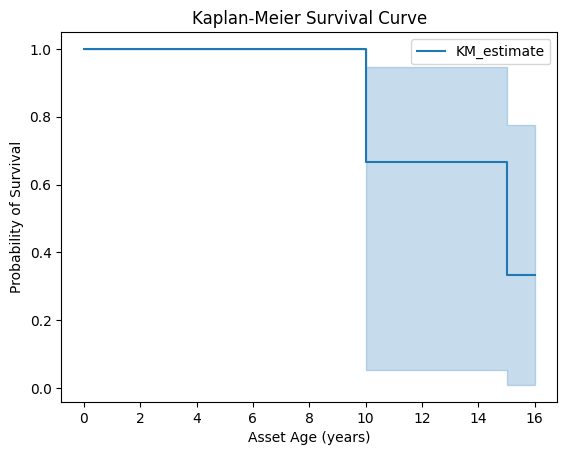

In [26]:
import matplotlib.pyplot as plt

plt.figure()

kmf.plot_survival_function()

plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Asset Age (years)")
plt.ylabel("Probability of Survival")

plt.show()

In [27]:
kmf.median_survival_time_

np.float64(15.0)